# Exploring Ensemble Methods

## Import module

In [1]:
# Import module
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

## Load data

In [10]:
# Load data
loans = pd.read_csv("lending-club-data.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Explore some features

Let's quickly explore what the dataset looks like.

In [11]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as a safe loan,
* -1 as a risky (bad) loan.

We put this in a new column called `safe_loans`.

In [12]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: 1 if x==0 else -1)
loans = loans.drop('bad_loans',1)

In [13]:
# Let's explore the distribution of safeloans
print("Number of safe loans: ", sum(loans['safe_loans']==1))
print("Number of bad loans: ", sum(loans['safe_loans']==-1))
print("Total number of loans: ", len(loans))

Number of safe loans:  99457
Number of bad loans:  23150
Total number of loans:  122607


## Selecting features

The features we will be using are described in the code comments below:

In [14]:
# Selecting Features
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to skip observations that contain missing values.

We run the following code to do so:

In [16]:
# Skipping observations with missing values
loans = loans[[target] + features].dropna()

## Load train-validation data

In [17]:
train_idx = pd.read_json("train-idx.json")
validation_idx = pd.read_json("validation-idx.json")
train_data = loans.iloc[train_idx[0].values]
validation_data = loans.iloc[validation_idx[0].values]

## One-hot encoding

In [18]:
# one-hot encoding
print("Data types: \n", train_data.dtypes)
categorical_variables = ['grade','home_ownership','purpose']
train_one_hot_encoded = pd.get_dummies(train_data,columns=categorical_variables)
train_target = train_one_hot_encoded['safe_loans']
train_features = train_one_hot_encoded.drop('safe_loans',axis = 1)

Data types: 
 safe_loans                 int64
grade                     object
sub_grade_num            float64
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
payment_inc_ratio        float64
delinq_2yrs              float64
delinq_2yrs_zero         float64
inq_last_6mths           float64
last_delinq_none           int64
last_major_derog_none      int64
open_acc                 float64
pub_rec                  float64
pub_rec_zero             float64
revol_util               float64
total_rec_late_fee       float64
int_rate                 float64
total_rec_int            float64
annual_inc               float64
funded_amnt                int64
funded_amnt_inv            int64
installment              float64
dtype: object


## Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

We will now train models to predict safe_loans using the features above.

In [19]:
ensemble_classifier = GradientBoostingClassifier(max_depth=6, n_estimators=5).fit(train_features,train_target)

## Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples from the validation set. We will do the following:

* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [20]:
# Making predictions
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
# one-hot encoding for validation data
validation_one_encoded = pd.get_dummies(validation_data,columns=categorical_variables)
validation_features = validation_one_encoded.drop('safe_loans',axis=1)

In [21]:
sample_validation_data

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
22,1,B,0.2,0,3,MORTGAGE,29.44,credit_card,6.30496,0.0,...,0.0,1.0,93.9,0.0,9.91,823.48,92000.0,15000,15000,483.38
26,1,B,0.6,1,1,RENT,12.19,credit_card,13.49520,0.0,...,0.0,1.0,59.1,0.0,11.71,1622.21,25000.0,8500,8500,281.15
24,-1,D,0.4,0,3,RENT,13.97,other,2.96736,3.0,...,0.0,1.0,59.5,0.0,16.77,719.11,50004.0,5000,5000,123.65
41,-1,A,1.0,0,11,MORTGAGE,16.33,debt_consolidation,1.90524,0.0,...,0.0,1.0,62.1,0.0,8.90,696.99,100000.0,5000,5000,158.77


### Predicting on sample validation data & probabilities

For each row in the **sample_validation_data**, write code to predict whether or not the loan is classified as a safe loan.

In [24]:
sample_validation_features = validation_features.loc[sample_validation_data.index]
print("Prediction with ensemble method (max_depth = 6, estimators: 5):, \n", ensemble_classifier.predict(sample_validation_features))

Prediction with ensemble method (max_depth = 6, estimators: 5):, 
 [ 1  1 -1  1]


In [26]:
ensemble_prob = pd.DataFrame(ensemble_classifier.predict_proba(sample_validation_features))
ensemble_prob = ensemble_prob.rename(columns={0:'RISKY',1:'SAFE'})
print("Prediction with ensemble method (max_depth = 6, estimators: 5) (Prob): \n")
ensemble_prob

Prediction with ensemble method (max_depth = 6, estimators: 5) (Prob): 



,RISKY,SAFE
0,0.416423,0.583577
1,0.469497,0.530503
2,0.538078,0.461922
3,0.395916,0.604084


## Evaluating the model on the validation data

Recall that the accuracy is defined as follows: 

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

In [27]:
# Accuracy
print("Accuracy (Validation Data): %.4g" %ensemble_classifier.score(validation_features,validation_data['safe_loans']))

Accuracy (Validation Data): 0.6612


In [28]:
# Quantifying the cost of mistakes
predictions = ensemble_classifier.predict(validation_features)
print("Number of Samples: ", len(predictions))
false_positives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == -1).sum()
false_negatives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == +1).sum()
print("FALSE Positive: ", false_positives)
print("FALSE Negative: ", false_negatives)

Number of Samples:  9284
FALSE Positive:  1654
FALSE Negative:  1491


## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around 0.64 (rounded). In this assignment, we saw that model_5 has an accuracy of 0.67 (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of model_5 in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model.

In [29]:
# Assume a cost of \$10,000 per false negative.
# Assume a cost of \$20,000 per false positive.
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print("Cost of Mistakes: ", cost_of_mistakes)

Cost of Mistakes:  47990000


## Most positive & negative loans

In [31]:
# Most positive & negative loans.
prob = pd.DataFrame(ensemble_classifier.predict_proba(validation_features)[:,1],index=validation_features.index, columns=['predictions'])
validation_data = validation_data.assign(predictions = prob)

In [32]:
print("Most Positive Predictions: \n")
validation_data[['grade','predictions']].sort_values(by='predictions',ascending = False).head(5)

Most Positive Predictions: 



,grade,predictions
8021,A,0.673059
15170,A,0.661468
15072,A,0.661468
90263,A,0.661468
7650,A,0.661468


In [34]:
print("Most Negative Predictions: \n") 
validation_data[['grade','predictions']].sort_values(by='predictions',ascending = True).head(5)

Most Negative Predictions: 



,grade,predictions
84508,C,0.307334
58794,C,0.307334
27502,C,0.312806
114781,D,0.315973
84921,C,0.315973


## Effect of adding more trees

In [35]:
# Effect of adding more trees
ensemble_classifier_est_10 = GradientBoostingClassifier(max_depth=6, n_estimators=10).fit(train_features,train_target)
ensemble_classifier_est_50 = GradientBoostingClassifier(max_depth=6, n_estimators=50).fit(train_features,train_target)
ensemble_classifier_est_100 = GradientBoostingClassifier(max_depth=6, n_estimators=100).fit(train_features,train_target)
ensemble_classifier_est_200 = GradientBoostingClassifier(max_depth=6, n_estimators=200).fit(train_features,train_target)
ensemble_classifier_est_500 = GradientBoostingClassifier(max_depth=6, n_estimators=500).fit(train_features,train_target)

## Compare accuracy on entire validation set

In [36]:
# Accuracy
print("Accuracy (n_estimator = 10, Validation Data): %.4g" %ensemble_classifier_est_10.score(validation_features,validation_data['safe_loans']))
print("Accuracy (n_estimator = 50, Validation Data): %.4g" %ensemble_classifier_est_50.score(validation_features,validation_data['safe_loans']))
print("Accuracy (n_estimator = 100, Validation Data): %.4g" %ensemble_classifier_est_100.score(validation_features,validation_data['safe_loans']))
print("Accuracy (n_estimator = 200, Validation Data): %.4g" %ensemble_classifier_est_200.score(validation_features,validation_data['safe_loans']))
print("Accuracy (n_estimator = 500, Validation Data): %.4g" %ensemble_classifier_est_500.score(validation_features,validation_data['safe_loans']))

Accuracy (n_estimator = 10, Validation Data): 0.6654
Accuracy (n_estimator = 50, Validation Data): 0.685
Accuracy (n_estimator = 100, Validation Data): 0.6889
Accuracy (n_estimator = 200, Validation Data): 0.6859
Accuracy (n_estimator = 500, Validation Data): 0.6868


## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models.

Make sure this block of code runs on your computer.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

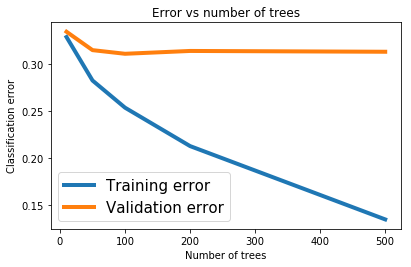

In [39]:
# Training Errors
train_err_10 = 1 - ensemble_classifier_est_10.score(train_features,train_data['safe_loans'])
train_err_50 = 1 - ensemble_classifier_est_50.score(train_features,train_data['safe_loans'])
train_err_100 = 1 - ensemble_classifier_est_100.score(train_features,train_data['safe_loans'])
train_err_200 = 1 - ensemble_classifier_est_200.score(train_features,train_data['safe_loans'])
train_err_500 = 1 - ensemble_classifier_est_500.score(train_features,train_data['safe_loans'])
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

# Validation Errors
validation_err_10 = 1 - ensemble_classifier_est_10.score(validation_features,validation_data['safe_loans'])
validation_err_50 = 1 - ensemble_classifier_est_50.score(validation_features,validation_data['safe_loans'])
validation_err_100 = 1 - ensemble_classifier_est_100.score(validation_features,validation_data['safe_loans'])
validation_err_200 = 1 - ensemble_classifier_est_200.score(validation_features,validation_data['safe_loans'])
validation_err_500 = 1 - ensemble_classifier_est_500.score(validation_features,validation_data['safe_loans'])
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')